Final Project Submission
</br>Please fill out:
</br>Student name: Dhruv Ragunathan
</br>Student pace: part time
</br>Scheduled project review date/time:
</br>Instructor name: Mark Barbour
</br>Blog post URL:

# Background

Pneumonia is an infection that inflames the lungs from many potential vectors: Bacteria, Viruses, Fungi, etc. Pneumonia is a potentially fatal infection, that if not identified early on could put the patient's life at risk especially in acute-care settings.

Data sets off lungs with Pneumonia and healthy lungs were provided by Guangzhou Women and Children’s Medical Center, Guangzhou.


![image.png](attachment:image.png)


Figure S6. Illustrative Examples of Chest X-Rays in Patients with Pneumonia, Related to Figure 6
The normal chest X-ray (left panel) depicts clear lungs without any areas of abnormal opacification in the image. Bacterial pneumonia (middle) typically exhibits a focal lobar consolidation, in this case in the right upper lobe (white arrows), whereas viral pneumonia (right) manifests with a more diffuse ‘‘interstitial’’ pattern in both lungs.

The link to download the dataset is here. The dataset was downloaded from this link

https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

# Business Objectives

The goal is to create a model that accurately predicts if an X-ray of a lung has pneumonia. The model will optimize on accuracy because we can save lives by accurately predicting lungs that have pneumonia.

The model will be deployed in a hospital where time is critical. Identifying someone who has pneumonia hours before complications occur can save lives.

This might mean that false positives are identified, scenarios where the model predicted that an x-ray has pneumonia when it really did not. This is ok in the business context because hospital staff can view other symptoms or other lab data to confirm if pnemonia is present or not.


# Google Colab Code

Commenting this out on the version in github. Feel free to comment out if running on google colab.

In [ ]:
# to upload files
from google.colab import files

# install Kaggle library
# !pip list
# !pip install -q kaggle

In [ ]:
# upload kaggle API key file
uploaded = files.upload()

Saving kaggle.json to kaggle (1).json


In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!mkdir 'Dataset'

In [ ]:
!cp /content/chest-xray-pneumonia.zip /content/Dataset/chest-xray-pneumonia.zip
!unzip -q /content/Dataset/chest-xray-pneumonia.zip -d /content/Dataset
!rm /content/Dataset/chest-xray-pneumonia.zip

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# Data Exploration

Data contains 3 data sets, train, test, and validation. In each file, there are two folders: Pneumonia and normal. Images in the Pneumonia file are named depending on whether the source off the infection is bacterial or viral.

First separate them out based on whether they are normal or have pneumonia.

The images that contain pneumonia are divided based on whether the cause off the ailment was bacterial or viral. Since the purpose of the model is too determine whether Pneumonia is present, we will not distinguish or aim to predict the source off the pneumonia.

However, this distinction will come into play later in the analysis when we investigate the parts off the image the model used to determine if pneumonia is present or not. There is a difference in what part off the lung the model uses to distinguish between the two depending on the source.

In [40]:
# Import data sets

import os, shutil
import time
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import numpy as np
import seaborn as sns
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn. metrics import recall_score, confusion_matrix
np.random.seed(42)

In [ ]:
folders = {}
train = {}
test = {}
test = {}
val = {}

main_folder = "/content/Dataset/chest_xray"

train_folder = main_folder + "/train"
train_P = train_folder + "/PNEUMONIA"
train_N = train_folder + "/NORMAL"

test_folder = main_folder + "/test"
test_P = test_folder + "/PNEUMONIA"
test_N = test_folder + "/NORMAL"

val_folder = main_folder + "/val"
val_P = val_folder + "/PNEUMONIA"
val_N = val_folder + "/NORMAL"


pneu_folds = [train_P,test_P,val_P] #put all pneumonia file paths in one list

normal_folds = [train_N,test_N,val_N] #Put all normal file paths in one list

all_folds = [pneu_folds,normal_folds]




In [ ]:
"""

The code below looks at all the file paths. It counts the number of images in each file path and determines
the total number of images with pneumonia or that are normal.

"""



total_normal = 0
total_pneumonia = 0

total_train_P = 0
total_train_N = 0

total_test_P = 0
total_test_N = 0

total_val_P = 0
total_val_N = 0

for folders in all_folds:

    for file_path in folders:

        folder = file_path.split("/") #Split the file path based on the /

        folder_name = folder[5] # Tells us if the folder is for PNEUMONIA or Normal Images
        folder_data = folder[4] # Tells us if the folder is for the training, testing, or val data

        if folder_name == 'PNEUMONIA':

            num_imgs = len([file for file in os.listdir(data_set) if file.endswith('.jpeg')])


            total_pneumonia = total_pneumonia + num_imgs

            if folder_data == 'train':

                total_train_P = num_imgs

            if folder_data == 'test':

                total_test_P = num_imgs


            if folder_data == 'val':

                total_val_P = num_imgs


        if folder_name == 'NORMAL':

            num_imgs = len([file for file in os.listdir(data_set) if file.endswith('.jpeg')])

            total_normal = total_normal + num_imgs

            if folder_data == 'train':

                total_train_N = num_imgs

            if folder_data == 'test':

                total_test_N = num_imgs


            if folder_data == 'val':

                total_val_N = num_imgs


total_images = total_pneumonia + total_normal




In [ ]:
print('There are',total_images, 'images total')

print('There are',total_pneumonia, 'lungs with pneumonia')

print('There are',total_normal, 'lungs without pneumonia')

There are 5856 images total
There are 4273 lungs with pneumonia
There are 1583 lungs without pneumonia


In [ ]:
total_train_P
total_train_N

total_test_P
total_test_N

total_val_P
total_val_N


print('In the train data set the split between pneumonia and normal lungs is ',total_train_P,' and ',total_train_N,' respectively.')
print('In the test data set the split between pneumonia and normal lungs is ',total_test_P,' and ',total_test_N,' respectively.')
print('In the validation data set the split between pneumonia and normal lungs is ',total_val_P,' and ',total_val_N,' respectively.')

In the train data set the split between pneumonia and normal lungs is  3875  and  1341  respectively.
In the test data set the split between pneumonia and normal lungs is  390  and  234  respectively.
In the train data set the split between pneumonia and normal lungs is  8  and  8  respectively.


The split between the training, testing, and validation data is not ideal. The data in the validation dataset is miniscule (16) compared to the training and testing set (~5200 and ~600, respectively). Later we will combine the data before doing train-test splits.

<BarContainer object of 2 artists>

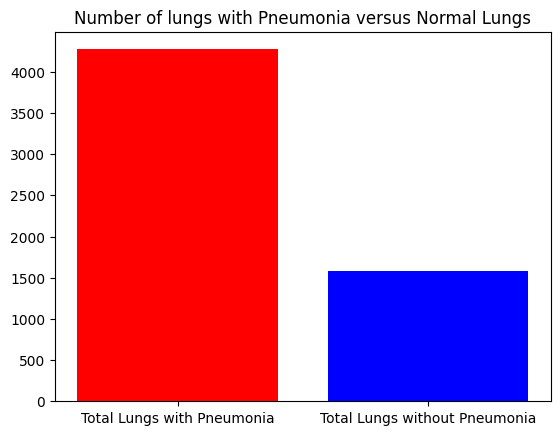

In [ ]:
# Visualize total number of infected lungs versus uninfected

plt.title("Number of lungs with Pneumonia versus Normal Lungs")
plt.bar(["Total Lungs with Pneumonia", "Total Lungs without Pneumonia"], [total_pneumonia,total_normal], color = ["r","b"])

The number of lungs with pneumonia is nearly 3 times greater than the number of lungs without. This means that if a model predicted that every image had pneumonia on this data set, it would be accurate 75% of the time. This context is important when evaluating the models in the latter part of the notebook.

# Data Preparation

The Process to prepare the data was as follows:
1. First we used Image Data Generator on the images in the test, train, and val data.
2. Then we created the labels for the target variable. Whether an xray is for a patient with Pneumonia or not.
3. Due to the disparities between the given training, testing, and val set, all data was combined into one dataset.
4. Data then split into training and testing sets. Since Neural Networks are computationally expensive. Two train test splits were done too reduce the size. The final training data set contained nearly 2500 images.

In [ ]:
# get all the data in the directory split/test (624 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder,
         batch_size = 624)

# get all the data in the directory split/validation (16 images), and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder,
        batch_size = 16)

# get all the data in the directory split/train (5216 images), and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_folder,
        batch_size=5216)

Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.


In [ ]:
# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [ ]:
# Explore your dataset again
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 5216
Number of testing samples: 624
Number of validation samples: 16
train_images shape: (5216, 256, 256, 3)
train_labels shape: (5216, 2)
test_images shape: (624, 256, 256, 3)
test_labels shape: (624, 2)
val_images shape: (16, 256, 256, 3)
val_labels shape: (16, 2)


In [ ]:
# combine three original datasets into one for data and labels
X = np.concatenate((train_images, test_images, val_images))
y_labels = np.concatenate((train_labels, test_labels, val_labels))

In [ ]:
# total dataset size
X.shape

(5856, 256, 256, 3)

In [ ]:
y = np.reshape(y_labels[:,0], (5856,1))

In [ ]:
# Further Explore Dataset

m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 5216
Number of testing samples: 624
Number of validation samples: 16
train_images shape: (5216, 256, 256, 3)
train_labels shape: (5216, 2)
test_images shape: (624, 256, 256, 3)
test_labels shape: (624, 2)
val_images shape: (16, 256, 256, 3)
val_labels shape: (16, 2)


## Train - Test Data Split

Using the full training data is not ideal to iteratively determine model parameters. The complete training set takes around 30 minutes to run with straightforward parameters (i.e. one convulution layer, one pooling layer, and one dense layer).

The strategy here is too split the data set into a smaller chunk.

### Convolutional Neural Network Data Preparation

Now we need to do a train test split to the data formatted for the Convolutional Neural Network.

In [ ]:
# First split the data into half. 

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X,y, test_size= 0.5)

In [ ]:
# Then split again by 15%

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_train_1, y_train_1, test_size= 0.15)

# Modeling

## First Convolution Neural Network

Base model is a simple convolution neural network. Contains one convolution layer, one pooling layer, and 10 neurons in the dense layer.

This model has achieved a ~96% accuracy on the training data set and a 95% accuracy on the testing data set.

In [ ]:
model_cnn_1 = models.Sequential()

# add convolutional and pooling layers
model_cnn_1.add(layers.Conv2D(8, (4, 4), activation='relu',
                        input_shape=(256 ,256,  3)))
model_cnn_1.add(layers.MaxPooling2D((2, 2)))

# flatten pooled featrue maps
model_cnn_1.add(layers.Flatten())

# add dense hidden layer and output
model_cnn_1.add(layers.Dense(10, activation='relu'))
model_cnn_1.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
# compile model
model_cnn_1.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# fit model to training data and validate
cnn_history_1 = model_cnn_1.fit(X_train_2,
                    y_train_2,
                    epochs=30,
                    batch_size=32,
                    validation_data=(X_test_2, y_test_2))

Epoch 1/30
78/78 [==============================] - 23s 285ms/step - loss: 0.5690 - accuracy: 0.7251 - val_loss: 0.4505 - val_accuracy: 0.7523
Epoch 2/30
78/78 [==============================] - 21s 271ms/step - loss: 0.4567 - accuracy: 0.7990 - val_loss: 0.3088 - val_accuracy: 0.8432
Epoch 3/30
78/78 [==============================] - 21s 273ms/step - loss: 0.3519 - accuracy: 0.8436 - val_loss: 0.2587 - val_accuracy: 0.8750
Epoch 4/30
78/78 [==============================] - 22s 278ms/step - loss: 0.2987 - accuracy: 0.8662 - val_loss: 0.2227 - val_accuracy: 0.8955
Epoch 5/30
78/78 [==============================] - 21s 275ms/step - loss: 0.2796 - accuracy: 0.8834 - val_loss: 0.1921 - val_accuracy: 0.9295
Epoch 6/30
78/78 [==============================] - 21s 270ms/step - loss: 0.2285 - accuracy: 0.9104 - val_loss: 0.2366 - val_accuracy: 0.9227
Epoch 7/30
78/78 [==============================] - 22s 276ms/step - loss: 0.2118 - accuracy: 0.9124 - val_loss: 0.2626 - val_accuracy: 0.8795

In [ ]:
model_cnn_1.save("/content/gdrive/My Drive/cnn_1_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
conv_results_train_1 = model_cnn_1.evaluate(X_train_2, y_train_2)

78/78 [==============================] - 5s 70ms/step - loss: 0.0999 - accuracy: 0.9642


In [ ]:
conv_results_test_1 = model_cnn_1.evaluate(X_test_2, y_test_2)

14/14 [==============================] - 1s 68ms/step - loss: 0.1212 - accuracy: 0.9545


In [ ]:
cnn_1_preds = model_cnn_1.predict(X_test_2)



14/14 [==============================] - 1s 69ms/step


In [ ]:
conv_results_test_1

[0.12116708606481552, 0.9545454382896423]

This model has achieved a ~96% accuracy on the training data set and a 95% accuracy on the testing data set.

The high and consistent accuracy between the training data set and testing dataset indicates that the model performed well.

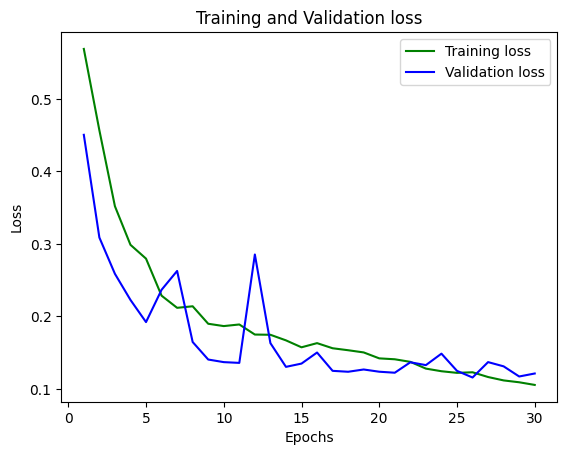

In [ ]:
cnn_model_1_val_dict = cnn_history_1.history
loss_values1 = cnn_model_1_val_dict["loss"]
val_loss_values1= cnn_model_1_val_dict["val_loss"]

epochs = range(1,len(loss_values1) + 1)
plt.plot(epochs, loss_values1, "g", label="Training loss")
plt.plot(epochs, val_loss_values1, "blue", label="Validation loss")

plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

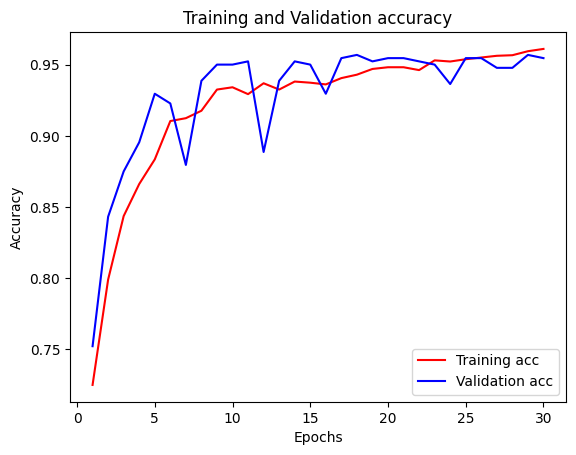

In [ ]:
acc_values1 = cnn_model_1_val_dict["accuracy"]
val_acc_values1 = cnn_model_1_val_dict["val_accuracy"]

plt.plot(epochs, acc_values1, "r", label="Training acc")
plt.plot(epochs, val_acc_values1, "blue", label="Validation acc")

plt.title("Training and Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Second Colvolutional Neural Networks
* Add two more Convolutional Layers
* Increase Dense Layer to 30 neurons

Accuracy of training and testing data is 96%.

In [ ]:
model_cnn_2 = models.Sequential()

# add 3 convolutional and pooling layers
model_cnn_2.add(layers.Conv2D(8, (4, 4), activation='relu',
                        input_shape=(256 ,256,  3)))
model_cnn_2.add(layers.MaxPooling2D((2, 2)))

# Second Convolutional Layer

model_cnn_2.add(layers.Conv2D(8, (4, 4), activation='relu',
                        input_shape=(256 ,256,  3)))
model_cnn_2.add(layers.MaxPooling2D((2, 2)))

#Third Convolutional Layer

model_cnn_2.add(layers.Conv2D(8, (4, 4), activation='relu',
                        input_shape=(256 ,256,  3)))
model_cnn_2.add(layers.MaxPooling2D((2, 2)))

# flatten pooled featrue maps
model_cnn_2.add(layers.Flatten())

# add dense hidden layer and output
model_cnn_2.add(layers.Dense(30, activation='relu'))
model_cnn_2.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
# compile model
model_cnn_2.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# fit model to training data and validate
cnn_history_2 = model_cnn_2.fit(X_train_2,
                    y_train_2,
                    epochs=30,
                    batch_size=32,
                    validation_data=(X_test_2, y_test_2))

Epoch 1/30
78/78 [==============================] - 36s 457ms/step - loss: 0.5963 - accuracy: 0.7227 - val_loss: 0.5612 - val_accuracy: 0.7500
Epoch 2/30
78/78 [==============================] - 34s 431ms/step - loss: 0.5294 - accuracy: 0.7363 - val_loss: 0.4192 - val_accuracy: 0.7568
Epoch 3/30
78/78 [==============================] - 33s 422ms/step - loss: 0.4341 - accuracy: 0.8163 - val_loss: 0.3189 - val_accuracy: 0.8841
Epoch 4/30
78/78 [==============================] - 34s 434ms/step - loss: 0.3398 - accuracy: 0.8609 - val_loss: 0.4231 - val_accuracy: 0.8136
Epoch 5/30
78/78 [==============================] - 33s 426ms/step - loss: 0.2912 - accuracy: 0.8794 - val_loss: 0.2574 - val_accuracy: 0.8773
Epoch 6/30
78/78 [==============================] - 33s 430ms/step - loss: 0.2557 - accuracy: 0.8983 - val_loss: 0.1948 - val_accuracy: 0.9364
Epoch 7/30
78/78 [==============================] - 33s 426ms/step - loss: 0.2326 - accuracy: 0.9100 - val_loss: 0.1822 - val_accuracy: 0.9455

In [ ]:
model_cnn_2.save("/content/gdrive/My Drive/cnn_2_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
conv_results_train_2 = model_cnn_2.evaluate(X_train_2, y_train_2)

78/78 [==============================] - 7s 89ms/step - loss: 0.0992 - accuracy: 0.9678


In [ ]:
conv_results_test_2 = model_cnn_2.evaluate(X_test_2, y_test_2)

14/14 [==============================] - 1s 86ms/step - loss: 0.1082 - accuracy: 0.9591


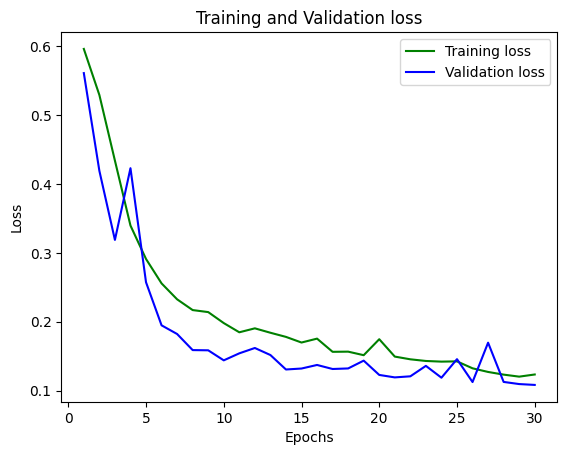

In [ ]:
cnn_model_2_val_dict = cnn_history_2.history
loss_values2 = cnn_model_2_val_dict["loss"]
val_loss_values2= cnn_model_2_val_dict["val_loss"]

epochs = range(1,len(loss_values2) + 1)
plt.plot(epochs, loss_values2, "g", label="Training loss")
plt.plot(epochs, val_loss_values2, "blue", label="Validation loss")

plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Interestingly, increasing the dense layer and adding two convolution layers decreased the accuracy of the model on test data.

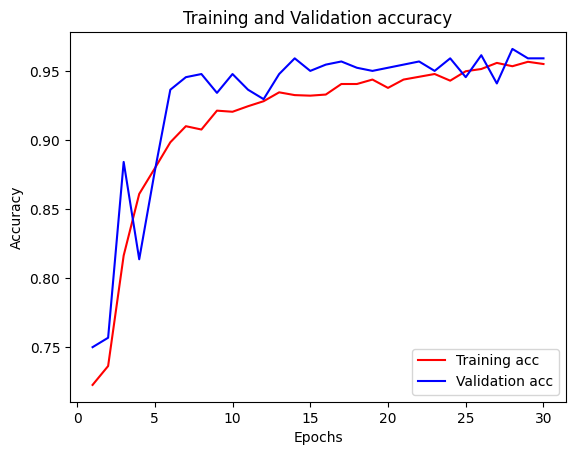

In [ ]:
acc_values2 = cnn_model_2_val_dict["accuracy"]
val_acc_values2 = cnn_model_2_val_dict["val_accuracy"]

plt.plot(epochs, acc_values2, "r", label="Training acc")
plt.plot(epochs, val_acc_values2, "blue", label="Validation acc")

plt.title("Training and Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Third Convolution Neural Network

* Three Convolution layers
* Three Pooling layers
* 30 neurons in the dense layer
* Added a dropout parameter of 0.25

Adding a dropout rate did not significantly change the accuracy off the models. The training accuracy was 94% and the testing accuracy was 95%.

In [ ]:
# First Convolutional Layer

model_cnn_3 = models.Sequential()
model_cnn_3.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256 ,256,  3)))
model_cnn_3.add(layers.MaxPooling2D((2, 2)))
model_cnn_3.add(layers.Dropout(0.25))

# Second Convolutional Layer

model_cnn_3.add(layers.Conv2D(8, (4, 4), activation='relu',
                        input_shape=(256 ,256,  3)))
model_cnn_3.add(layers.MaxPooling2D((2, 2)))
model_cnn_3.add(layers.Dropout(0.25))


#Third Convolutional Layer

model_cnn_3.add(layers.Conv2D(8, (4, 4), activation='relu', input_shape=(256 ,256,  3)))
model_cnn_3.add(layers.MaxPooling2D((2, 2)))
model_cnn_3.add(layers.Dropout(0.25))


model_cnn_3.add(layers.Flatten())
model_cnn_3.add(layers.Dense(30, activation='relu'))
model_cnn_3.add(layers.Dropout(0.25))
model_cnn_3.add(layers.Dense(1, activation='sigmoid'))

model_cnn_3.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])



In [ ]:
cnn_history_3 = model_cnn_3.fit(X_train_2,
                    y_train_2,
                    epochs=30,
                    batch_size=32,
                    validation_data=(X_test_2, y_test_2))

Epoch 1/30
78/78 [==============================] - 65s 817ms/step - loss: 0.5968 - acc: 0.7223 - val_loss: 0.5694 - val_acc: 0.7500
Epoch 2/30
78/78 [==============================] - 63s 804ms/step - loss: 0.5248 - acc: 0.7488 - val_loss: 0.4541 - val_acc: 0.8841
Epoch 3/30
78/78 [==============================] - 67s 854ms/step - loss: 0.4264 - acc: 0.8107 - val_loss: 0.3223 - val_acc: 0.9023
Epoch 4/30
78/78 [==============================] - 64s 818ms/step - loss: 0.3327 - acc: 0.8585 - val_loss: 0.2719 - val_acc: 0.9000
Epoch 5/30
78/78 [==============================] - 63s 811ms/step - loss: 0.3022 - acc: 0.8754 - val_loss: 0.2140 - val_acc: 0.9341
Epoch 6/30
78/78 [==============================] - 63s 815ms/step - loss: 0.2672 - acc: 0.8935 - val_loss: 0.2370 - val_acc: 0.9023
Epoch 7/30
78/78 [==============================] - 65s 840ms/step - loss: 0.2479 - acc: 0.9076 - val_loss: 0.2156 - val_acc: 0.9432
Epoch 8/30
78/78 [==============================] - 64s 822ms/step - 

In [ ]:
#Code from Google Co-lab

#model_cnn_3.save("/content/gdrive/My Drive/cnn_3_model_v2.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Uncomment to load from Google Colab

#model_cnn_3 = keras.models.load_model('/content/gdrive/My Drive/cnn_3_model_v2.h5')


In [ ]:
conv_results_train_3 = model_cnn_3.evaluate(X_train_2, y_train_2)

78/78 [==============================] - 13s 165ms/step - loss: 0.1411 - acc: 0.9425


In [ ]:
conv_results_test_3 = model_cnn_3.evaluate(X_test_2, y_test_2)

14/14 [==============================] - 2s 160ms/step - loss: 0.1423 - acc: 0.9500


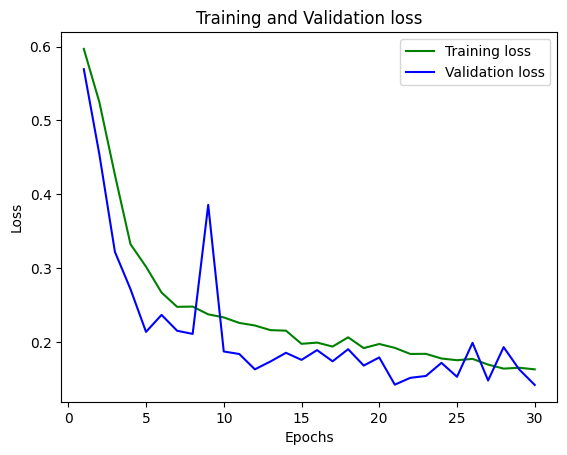

In [ ]:
cnn_model_3_val_dict = cnn_history_3.history
loss_values3 = cnn_model_3_val_dict["loss"]
val_loss_values3= cnn_model_3_val_dict["val_loss"]

epochs = range(1,len(loss_values3) + 1)
plt.plot(epochs, loss_values3, "g", label="Training loss")
plt.plot(epochs, val_loss_values3, "blue", label="Validation loss")

plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

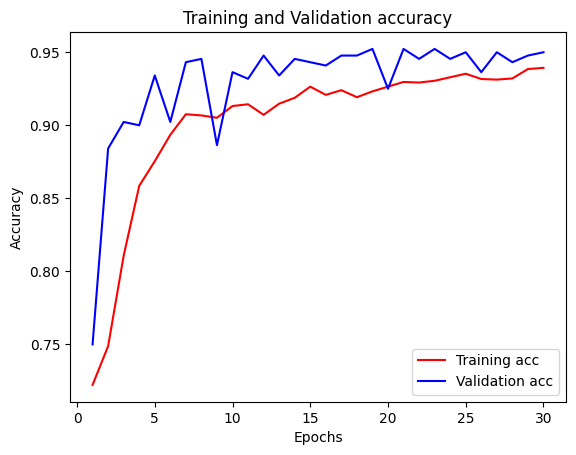

In [ ]:
acc_values3 = cnn_model_3_val_dict["acc"]
val_acc_values3 = cnn_model_3_val_dict["val_acc"]

plt.plot(epochs, acc_values3, "r", label="Training acc")
plt.plot(epochs, val_acc_values3, "blue", label="Validation acc")

plt.title("Training and Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Adding a dropout rate did not significantly change the accuracy off the models. The training accuracy was 94% and the testing accuracy was 95%.

## Fourth Convolution Neural Network

* Three Convolution layers
* Three Pooling layers
* 30 neurons in the dense layer
* Added a dropout parameter of 0.25
* L2 regularizer off 0.001 added

Training Accuracy is 93% and testing accuracy is 95%. The training accuracy dropped somewhat.

In [ ]:
# First Convolutional Layer

model_cnn_4 = models.Sequential()
model_cnn_4.add(layers.Conv2D(32, (3, 3), activation='relu',
                        kernel_regularizer=keras.regularizers.l2(l=0.001),input_shape=(256 ,256,  3)))
model_cnn_4.add(layers.MaxPooling2D((2, 2)))
model_cnn_4.add(layers.Dropout(0.25))

# Second Convolutional Layer

model_cnn_4.add(layers.Conv2D(8, (4, 4), activation='relu',
                              kernel_regularizer=keras.regularizers.l2(l=0.001),
                        input_shape=(256 ,256,  3)))
model_cnn_4.add(layers.MaxPooling2D((2, 2)))
model_cnn_4.add(layers.Dropout(0.25))


#Third Convolutional Layer

model_cnn_4.add(layers.Conv2D(8, (4, 4), activation='relu',
                              kernel_regularizer=keras.regularizers.l2(l=0.001),
                              input_shape=(256 ,256,  3)))
model_cnn_4.add(layers.MaxPooling2D((2, 2)))
model_cnn_4.add(layers.Dropout(0.25))

model_cnn_4.add(layers.Flatten())
model_cnn_4.add(layers.Dense(30, activation='relu'))
model_cnn_4.add(layers.Dropout(0.25))
model_cnn_4.add(layers.Dense(1, activation='sigmoid'))

model_cnn_4.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])



In [ ]:
cnn_history_4 = model_cnn_4.fit(X_train_2,
                    y_train_2,
                    epochs=30,
                    batch_size=32,
                    validation_data=(X_test_2, y_test_2))

Epoch 1/30
78/78 [==============================] - 68s 846ms/step - loss: 0.6325 - acc: 0.7195 - val_loss: 0.6383 - val_acc: 0.7500
Epoch 2/30
78/78 [==============================] - 65s 836ms/step - loss: 0.5820 - acc: 0.7303 - val_loss: 0.5649 - val_acc: 0.7705
Epoch 3/30
78/78 [==============================] - 66s 846ms/step - loss: 0.4769 - acc: 0.7934 - val_loss: 0.3785 - val_acc: 0.8227
Epoch 4/30
78/78 [==============================] - 64s 826ms/step - loss: 0.4098 - acc: 0.8412 - val_loss: 0.4031 - val_acc: 0.8818
Epoch 5/30
78/78 [==============================] - 64s 825ms/step - loss: 0.3539 - acc: 0.8613 - val_loss: 0.3290 - val_acc: 0.9295
Epoch 6/30
78/78 [==============================] - 64s 824ms/step - loss: 0.3251 - acc: 0.8782 - val_loss: 0.2814 - val_acc: 0.9341
Epoch 7/30
78/78 [==============================] - 65s 838ms/step - loss: 0.2973 - acc: 0.8951 - val_loss: 0.2569 - val_acc: 0.9364
Epoch 8/30
78/78 [==============================] - 64s 826ms/step - 

In [ ]:
# Save lab in google co-lab

#model_cnn_4.save("/content/gdrive/My Drive/cnn_4_model_v2.h5")

In [43]:
#model_cnn_4 = load_model('cnn_4_model_v2.h5')

OSError: SavedModel file does not exist at: cnn_4_model_v2.h5/{saved_model.pbtxt|saved_model.pb}

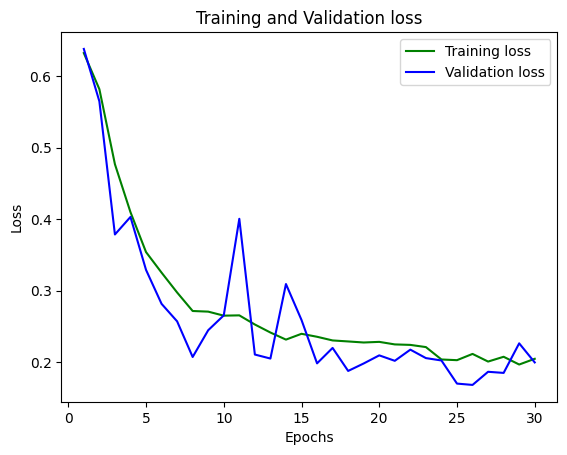

In [ ]:
cnn_model_4_val_dict = cnn_history_4.history
loss_values4 = cnn_model_4_val_dict["loss"]
val_loss_values4= cnn_model_4_val_dict["val_loss"]

epochs = range(1,len(loss_values4) + 1)
plt.plot(epochs, loss_values4, "g", label="Training loss")
plt.plot(epochs, val_loss_values4, "blue", label="Validation loss")

plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

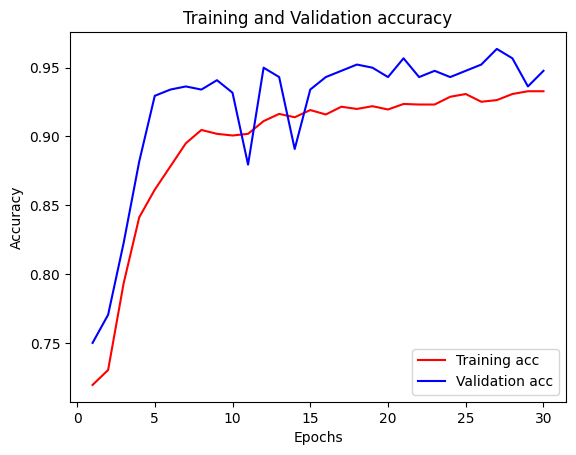

In [ ]:
acc_values4 = cnn_model_4_val_dict["acc"]
val_acc_values4 = cnn_model_4_val_dict["val_acc"]

plt.plot(epochs, acc_values4, "r", label="Training acc")
plt.plot(epochs, val_acc_values4, "blue", label="Validation acc")

plt.title("Training and Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Training Accuracy is 93% and testing accuracy is 95%. The training accuracy dropped somewhat.

# Model Evaluation

We've run 4 models. All have had very good accuracy (over 93%) on both the training and testing data. Let's run these models over the the larger testing data set that was split off earlier.

In [ ]:
# Run CNN #1

CNN_Results_1 = model_cnn_1.evaluate(X_test_1,y_test_1)

CNN_Results_1

92/92 [==============================] - 7s 73ms/step - loss: 0.1514 - accuracy: 0.9436


[0.15136241912841797, 0.943647563457489]

In [ ]:
# Run CNN #2

CNN_Results_2 = model_cnn_2.evaluate(X_test_1,y_test_1)

CNN_Results_2

92/92 [==============================] - 9s 94ms/step - loss: 0.1401 - accuracy: 0.9498


[0.1401091068983078, 0.9497950673103333]

In [ ]:
# Run CNN #3 Model

CNN_Results_3 = model_cnn_3.evaluate(X_test_1,y_test_1)

CNN_Results_3


92/92 [==============================] - 16s 178ms/step - loss: 0.1671 - acc: 0.9423


[0.16709178686141968, 0.9422814249992371]

In [ ]:
#Run CNN #4 Model

CNN_Results_4 = model_cnn_4.evaluate(X_test_1,y_test_1)

CNN_Results_4


92/92 [==============================] - 17s 185ms/step - loss: 0.2227 - acc: 0.9378


[0.2227245569229126, 0.937841534614563]

In [ ]:
Models_Accuracy = [CNN_Results_1[1],CNN_Results_2[1],CNN_Results_3[1],CNN_Results_4[1],]

Models_Accuracy

[0.943647563457489, 0.9497950673103333, 0.9422814249992371, 0.937841534614563]

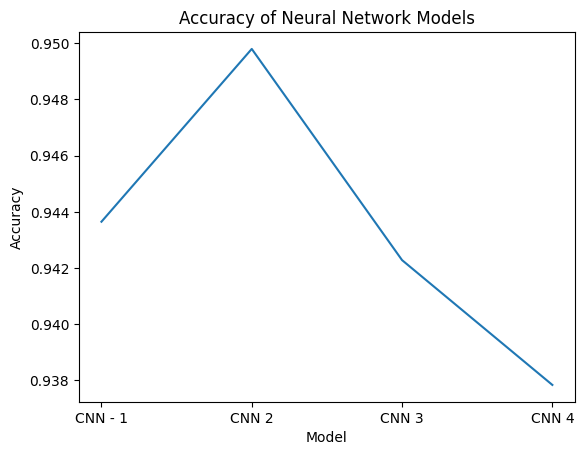

In [ ]:
sns.lineplot(x = ["CNN - 1","CNN 2","CNN 3", "CNN 4"],y = Models_Accuracy)

plt.title("Accuracy of Neural Network Models")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.show()

### Review of neural networks implemented above

* Base Neural Netork: No convolution. 3 layers.
* CNN 1: One Convolution layer
* CNN 2: Three Convolution Layers
* CNN 3: Dropout of 0.25 added
* CNN 4: Regularizer added

# Final Model Evaluation

Based on the accuracies above, the second neural network with three convolution layers and no regularizers or drop out had the highest accuracy.

Ultimately, all models had accuracies within a few percentage points within one - another. It would not be surprising if one of the models with regularization performed better on a different data set with significantly more records.

If this were based on accuracy alone then the second convolution neural network would be the choice. However, when reviewing the plots off the accuracy/loss over the epochs, we noticed that the models without any regulation had significant variance than the ones that did not.

Finding the variance in the final epocs gives us the following numbers.

In [ ]:
# First get the Last 10 values of the validation accuracy and store them in an array

cnn_1_acc_last_10 = cnn_model_1_val_dict["val_accuracy"][20:]

cnn_2_acc_last_10 = cnn_model_2_val_dict["val_accuracy"][20:]

cnn_3_acc_last_10 = cnn_model_3_val_dict["val_acc"][20:]

cnn_4_acc_last_10 = cnn_model_4_val_dict["val_acc"][20:]


# Get the standard deviation off those values

cnn_1_acc_std = np.std(cnn_1_acc_last_10)

cnn_2_acc_std = np.std(cnn_2_acc_last_10)

cnn_3_acc_std = np.std(cnn_3_acc_last_10)

cnn_4_acc_std = np.std(cnn_4_acc_last_10)


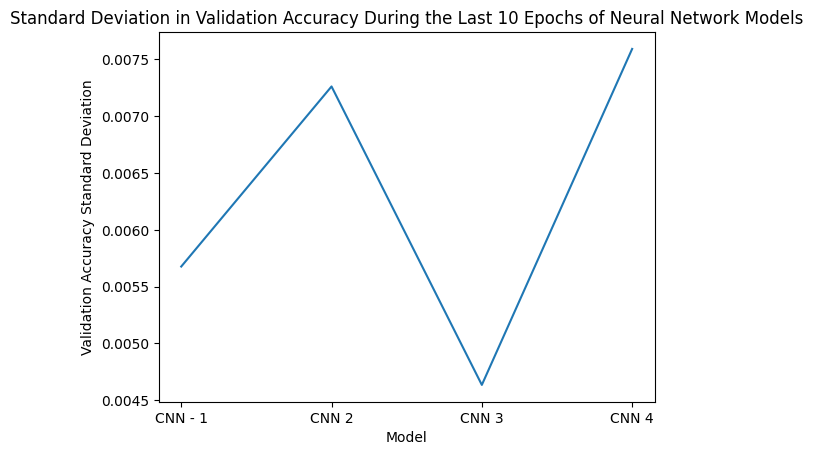

In [ ]:
Models_Std_lst_10 = [cnn_1_acc_std,cnn_2_acc_std,cnn_3_acc_std,cnn_4_acc_std]

sns.lineplot(x = ["CNN - 1","CNN 2","CNN 3", "CNN 4"],y = Models_Std_lst_10)

plt.title("Standard Deviation in Validation Accuracy During the Last 10 Epochs of Neural Network Models")
plt.xlabel("Model")
plt.ylabel("Validation Accuracy Standard Deviation")
plt.show()

## Charting the Standard Deviation in Accuracy during the Last 5 Epochs

In [ ]:
# First get the Last 5 values of the validation accuracy and store them in an array

cnn_1_acc_last_5 = cnn_model_1_val_dict["val_accuracy"][25:]

cnn_2_acc_last_5 = cnn_model_2_val_dict["val_accuracy"][25:]

cnn_3_acc_last_5 = cnn_model_3_val_dict["val_acc"][25:]

cnn_4_acc_last_5 = cnn_model_4_val_dict["val_acc"][25:]


# Get the standard deviation off those values

cnn_1_acc_std_5 = np.std(cnn_1_acc_last_5)

cnn_2_acc_std_5 = np.std(cnn_2_acc_last_5)

cnn_3_acc_std_5 = np.std(cnn_3_acc_last_5)

cnn_4_acc_std_5 = np.std(cnn_4_acc_last_5)


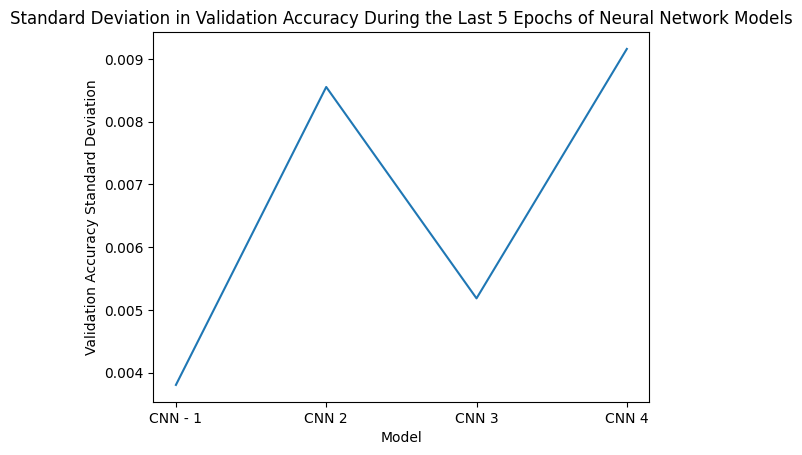

In [ ]:
Models_Std_lst_5 = [cnn_1_acc_std_5,cnn_2_acc_std_5,cnn_3_acc_std_5,cnn_4_acc_std_5]

sns.lineplot(x = ["CNN - 1","CNN 2","CNN 3", "CNN 4"],y = Models_Std_lst_5)

plt.title("Standard Deviation in Validation Accuracy During the Last 5 Epochs of Neural Network Models")
plt.xlabel("Model")
plt.ylabel("Validation Accuracy Standard Deviation")
plt.show()

In [ ]:
for i in range(0,4):
    print((Models_Std_lst_10[i]-Models_Std_lst_5[i])/(Models_Std_lst_10[i]))

0.3301358729429163
-0.17765683123096435
-0.11803398874989492
-0.20631551951240662


The Standard Deviation in the accuracy decreased for CNN models 1. It remained roughly the same in model 3, but increased in Models 2 and 4. Indicating that the models were getting more stable in their predictions. For CNN Model 2, the standard deviation increased instead.

Even though CNN model 2 had the highest accuracy, because it showed a high variance in accuracy during the epochs it will not be the final model selected.

The model selected will be CNN model 3. Model 3 has the next highest accuracy (94.5%)  and showed that the predictions were becoming stable as the number of epochs increased. As a result, this model is more likely to show less variability when utilized. This is likely due to the regularization, specifically the dropout parameter, added to this model.

Let's look at some of the parameters in the model.

In [ ]:
model_cnn_3.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 dropout_15 (Dropout)        (None, 127, 127, 32)      0         
                                                                 
 conv2d_16 (Conv2D)          (None, 124, 124, 8)       4104      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 62, 62, 8)         0         
 ng2D)                                                           
                                                                 
 dropout_16 (Dropout)        (None, 62, 62, 8)       

The final model is a convolutional neural network model. It consists of 3 convolutional layers, 3 pooling layers, a flattening layer, and two final dense layers. The convolutional layers have filters of size (3,3). The first layer has 32 filters, followed by 8 filters in the second.

Each layer has a dropout for regularization.

Max pooling is done with a (2,2) dimension. The first dense layer contains 30 neurons, and the output layer contains one neuron with a sigmoid activation function. The final model has a 94.5% accuracy.



# Feature Analysis

Let's look at the features and the parts of the image our model emphasized to determine if a lung was pneumatic. Given the amount of data in an image, we will show images of lungs from the data set and highlight the portions that were activated by the model.

In [ ]:
from keras.preprocessing import image

img_path = 'chest_xray/train/NORMAL/IM-0115-0001.jpeg'


img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

#Follow the Original Model Preprocessing
img_tensor /= 255.

#Check tensor shape
print(img_tensor.shape)

#Preview an image
plt.imshow(img_tensor[0])
plt.show()

(1, 256, 256, 3)
(1, 256, 256, 3)
Normal Lung


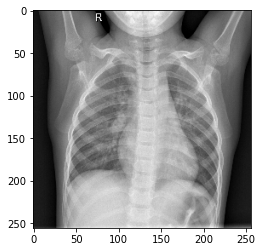

Pneumoniatic Lung


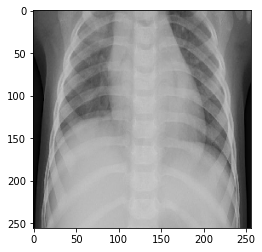

In [17]:
normal_img_path = 'chest_xray/train/NORMAL/IM-0115-0001.jpeg'
pneumonia_img_path = 'chest_xray/train/PNEUMONIA/person1_bacteria_1.jpeg'

#Create tensor for normal Image
normal_img = image.load_img(normal_img_path, target_size=(256, 256))
normal_img_tensor = image.img_to_array(normal_img)
normal_img_tensor = np.expand_dims(normal_img_tensor, axis=0)

#Create tensor for pneumonia image
pneumonia_img = image.load_img(pneumonia_img_path, target_size=(256, 256))
pneumonia_img_tensor = image.img_to_array(pneumonia_img)
pneumonia_img_tensor = np.expand_dims(pneumonia_img_tensor, axis=0)


#Follow the Original Model Preprocessing
normal_img_tensor /= 255.
pneumonia_img_tensor /=255.

#Check tensor shape
print(normal_img_tensor.shape)
print(pneumonia_img_tensor.shape)

#Preview an image
print("Normal Lung")
plt.imshow(normal_img_tensor[0])
plt.show()

print("Pneumoniatic Lung")
plt.imshow(pneumonia_img_tensor[0])
plt.show()

In [19]:
# Extract model layer outputs
layer_outputs = [layer.output for layer in cnn_model_4.layers[:8]]

# Rather then a model with a single output, we are going to make a model to display the feature maps
activation_model = cnn_model_4.Model(inputs=cnn_model_4.input, outputs=layer_outputs)

NameError: name 'cnn_model_4' is not defined